<a href="https://colab.research.google.com/github/lionelsaxer/DLSS/blob/main/Final_Essay_DLSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Essay DLSS Code

In [65]:
# Import Packages
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from collections import Counter
from operator import itemgetter
from google.colab import drive


In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [66]:
# setting a seed for reproducibility

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# import data set
df_vdem = pd.read_csv("/content/drive/MyDrive/V-Dem-CY-Full+Others-v13.csv",
                      usecols=["v2eltrnout", "country_name", "year",
                               "v2elvaptrn", "e_wb_pop", "v2elcomvot",
                               "v2elpubfin", "v2ellovtlg", "v2ellovtsm",
                               "v2elparlel"])

In [4]:
# change column order
df_vdem = df_vdem[["v2eltrnout", "country_name", "year", "v2elvaptrn",
                    "v2elcomvot", "v2elpubfin", "v2ellovtlg", "e_wb_pop",
                    "v2ellovtsm", "v2elparlel"]]

In [5]:
df_vdem.head()

,v2eltrnout,country_name,year,v2elvaptrn,v2elcomvot,v2elpubfin,v2ellovtlg,e_wb_pop,v2ellovtsm,v2elparlel
0,NaN,Mexico,1789,NaN,NaN,-2.176,NaN,NaN,NaN,NaN
1,NaN,Mexico,1790,NaN,NaN,-2.176,NaN,NaN,NaN,NaN
2,NaN,Mexico,1791,NaN,NaN,-2.176,NaN,NaN,NaN,NaN
3,NaN,Mexico,1792,NaN,NaN,-2.176,NaN,NaN,NaN,NaN
4,NaN,Mexico,1793,NaN,NaN,-2.176,NaN,NaN,NaN,NaN


In [6]:
# check no of NAs of RV and VAP turnout
df_vdem[["v2eltrnout", "v2elvaptrn"]].isna().sum()

v2eltrnout    24334
v2elvaptrn    25167
dtype: int64

In [7]:
# check shape of data frame
df_vdem.shape

(27555, 10)

In [ ]:
# mutate population variable and drop VAP turnout
#df_vdem["log_wb_pop"] = np.log(df_vdem["e_wb_pop"])
#df_vdem = df_vdem.drop(["e_wb_pop", "v2elvaptrn"], axis=1)

In [8]:
# drop VAP turnout
df_vdem = df_vdem.drop("v2elvaptrn", axis=1)

In [9]:
# look at data for Switzerland
df_vdem_Switzerland = df_vdem.loc[df_vdem["country_name"]=="Switzerland"]
df_vdem_Switzerland = df_vdem_Switzerland.dropna()

In [10]:
df_vdem_Switzerland

,v2eltrnout,country_name,year,v2elcomvot,v2elpubfin,v2ellovtlg,e_wb_pop,v2ellovtsm,v2elparlel
756,64.46,Switzerland,1963,0.0,-2.215,26.60,5694247.0,23.9,1.0
760,63.76,Switzerland,1967,0.0,-2.215,23.50,5991785.0,23.2,1.0
764,56.36,Switzerland,1971,0.0,-2.215,22.90,6213399.0,21.7,1.0
768,52.39,Switzerland,1975,0.0,-2.215,24.90,6338632.0,22.2,1.0
772,48.06,Switzerland,1979,0.0,-2.215,24.40,6294365.0,24.0,1.0
776,48.91,Switzerland,1983,0.0,-2.215,23.30,6418773.0,22.8,1.0
780,47.48,Switzerland,1987,0.0,-2.215,22.90,6545106.0,19.6,1.0
784,46.04,Switzerland,1991,0.0,-2.215,21.00,6799978.0,18.5,1.0
788,42.25,Switzerland,1995,0.0,-1.979,21.80,7040687.0,20.2,1.0
792,43.22,Switzerland,1999,0.0,-1.979,22.60,7143991.0,22.5,1.0


In [11]:
# remove missing values
df_vdem = df_vdem.dropna()
# check delay
c = Counter(df_vdem.country_name)
min_key, min_count = min(c.items(), key=itemgetter(1))
print(min_key, min_count)

Haiti 1


In [12]:
# let's see how many countries occur >= 3 times in the data set
print("Total number of countries:", len(df_vdem.country_name.unique()))
print(
    "Number of countries occuring at least 3 times:",
    len(
    df_vdem[df_vdem.groupby('country_name')['country_name']
            .transform('size') >= 3]
    .country_name.unique()
    )
  )

Total number of countries: 156
Number of countries occuring at least 3 times: 143


In [13]:
# check shape of data after removing NAs
df_vdem.shape

(1475, 9)

In [14]:
# normalize data
df_select = df_vdem.drop(["country_name", "year"], axis=1)
raw_data = df_select.to_numpy()

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

df_raw = pd.DataFrame(raw_data)
df_raw = df_raw.reset_index(drop=True)
df_vdem = df_vdem.reset_index(drop=True)

df_raw = pd.concat([df_raw, df_vdem[["country_name", "year"]]], axis=1)

In [15]:
df_raw.head()

,0,1,2,3,4,5,6,country_name,year
0,-0.047616,0.890017,-0.819980,2.548879,-0.167400,-1.552044,-1.122259,Mexico,1961
1,0.008773,0.890017,-0.246687,2.324203,-0.140439,-1.206896,1.511833,Mexico,1964
2,-0.399108,0.890017,-0.246687,2.189397,-0.110786,-1.136097,1.511833,Mexico,1967
3,-0.308885,0.890017,-0.246687,2.155696,-0.078636,-0.967948,1.511833,Mexico,1970
4,-0.556997,0.890017,-0.071730,1.824298,-0.044408,-0.782099,1.511833,Mexico,1973


In [16]:
def merge(data1, data2):
  x1, y1 = data1
  x2, y2 = data2
  return tf.concat([x1, x2], axis=-1), tf.concat([y1, y2], axis=-1)

In [93]:
k=1
for country in df_raw.country_name.unique():
  df_h=df_raw[df_raw.country_name==country]
  if df_h.shape[0]>15:
    #removing the country name
    print(country)
    df_h=df_h[[0, 1, 2, 3, 4, 5, 6]]

    raw_data=df_h.to_numpy()
    num_train_samples = int(0.5 * len(raw_data))
    num_val_samples = int(0.25 * len(raw_data))
    num_test_samples = len(raw_data) - num_train_samples - num_val_samples

    sampling_rate = 1 # every election
    sequence_length = 3 # use last 3 elections to predict
    delay = sampling_rate * (sequence_length - 1)
    batch_size = 512
    #index to predict
    targets0=pd.DataFrame(raw_data)[0].to_numpy()
  try:
    if k==1:
      train_dataset = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=0,
          end_index=num_train_samples)

      val_dataset = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=num_train_samples,
          end_index=num_train_samples + num_val_samples - 1)

      test_dataset = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=num_train_samples + num_val_samples - 1)
    else:
        train_dataset2 = keras.utils.timeseries_dataset_from_array(
          raw_data[:-delay],
          targets=targets0[delay:],
          sampling_rate=sampling_rate,
          sequence_length=sequence_length,
          shuffle=True,
          batch_size=batch_size,
          start_index=0,
          end_index=num_train_samples)

        val_dataset2 = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=targets0[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=True,
            batch_size=batch_size,
            start_index=num_train_samples,
            end_index=num_train_samples + num_val_samples - 1)

        test_dataset2 = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=targets0[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=True,
            batch_size=batch_size,
            start_index=num_train_samples + num_val_samples - 1)
        k=2


        train_dataset = tf.data.Dataset.zip((train_dataset, train_dataset2)).map(merge)
        val_dataset = tf.data.Dataset.zip((val_dataset, val_dataset2)).map(merge)
        test_dataset = tf.data.Dataset.zip((test_dataset, test_dataset2)).map(merge)

  except:
    k=k+1

Mexico
Sweden
Japan
Colombia
United States of America
Portugal
Canada
Australia
Germany
Ireland
Netherlands
Austria
Belgium
Bulgaria
Denmark
Finland
Greece
Iceland
Israel
New Zealand
Norway


In [94]:
targets0

array([0.61902869, 1.01751164, 0.9178909 , 0.69233451, 0.85836908,
       0.80197998, 0.92979527, 0.87528581, 0.41728102, 0.57266432,
       0.39409884, 0.51690176, 0.44986139, 0.56639886, 0.56577232,
       0.49998503])

In [95]:
for x, y in test_dataset:
  print(x.shape, y.shape)

(1, 3, 7) (1,)


In [96]:
#Naive Baseline from the Book github
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] #* std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.90
Test MAE: 1.07


In [101]:
# Estimate a simple, densely connected baseline
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(4)(inputs)
outputs = layers.Dense(1)(x) # predicting turnout
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("vdem_baseline.keras",
                                    save_best_only=True)
]
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks,
                    verbose=False)

model = keras.models.load_model("vdem_baseline.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

1/1 [==============================] - 0s 492ms/step - loss: 0.0222 - mae: 0.1489
Test MAE: 0.15


In [102]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 3, 7)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 4)                 192       
                                                                 
 dense_20 (Dense)            (None, 1)                 5         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


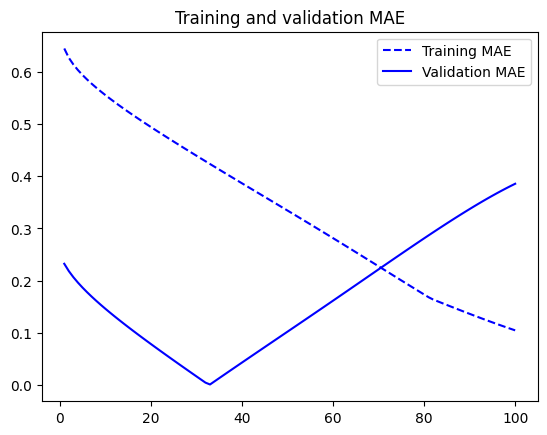

In [103]:
# Plot MAE for training and validation data
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# Dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("vdem_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=callbacks)